# Gradient Descent
Given we can calculate the gradient of our cost function, we can minimize it by moving in the opposite direction of the gradient using some learning rate. You already saw a minimal implementation of this for the `fit` function in `LogisticRegression`. Here, we want to try different Gradient Descent methods, by implementing them *independently* of the underlying model. This way we can simply pass a `gradient()` function to the **optimizer** and ask it to find the optimal set of parameters for our model -- that is we don't need a specialized implementation say for `LinearRegression` and `LogisticRegression`. While there are different ways we could have a separate optimizer, here, we define an optimizer class -- such as `StochasticGradientDescent` -- and pass an instance of this class to the `fit` function for our model. The `fit` function could then `run` the optimizer to fit the data. Here, we only implement the vanilla `GradientDescent` class, since other methods will be part of your project.

In [1]:
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

class GradientDescent:

    def __init__(self, learning_rate=1e-3, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                  # to store the weight history for visualization

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        if self.record_history:
            self.w_history.append(w)                # store initial weights before the iterative update
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)             # compute the gradient with present weight
            w = w - self.learning_rate * grad         # weight update step
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

Note that in the implementation above we added an option to record the history of model parameter's during gradient descent for the purpose of visualization.

Let's reimplement the `LinearRegression` class to use an optimizer. Note that the gradient depends on the loss function. Here we assume the loss function for the linear regression is Mean Squared Error (MSE):

\begin{equation}
    \frac{1}{N}\sum_{n} (\hat{y}^{(n)} - y^{(n)})^2
\end{equation}


## Linear regression implementation using a generic gradient function

In [2]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y, optimizer, gd=True):
        if x.ndim == 1:
            x = x[:, None]                    # add the column dimension
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])          # append a column of all 1's
        N,D = x.shape

        def gradient(x, y, w):                    # define the gradient function
            yh =  x @ w
            N, D = x.shape
            grad = np.dot(yh - y, x)/N             # assuming MSE loss
            return grad

        w_init = np.zeros(D)                     # initialize all the weights to 0

        if gd:
            self.w = optimizer.run(gradient, x, y, w_init)   # run the optimizer to get the optimal weights
        else:
            #alternatively:
            self.w = np.linalg.inv(x.T @ x)@x.T@y        # closed-form solution of weight
            # self.w = np.linalg.lstsq(x, y)[0]         # return w for the least square difference
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x @ self.w
        return yh

## A simple 1D toy simulation to understand GD
Let's simulate a toy data with true weight coefficents of -4 and bias of 10.
To make the model fitting more interesting, we add Gaussian noise of scale 10 to the output.

In [3]:
N = 20
x = np.random.rand(N) * 10
true_w = -4
noise = np.random.randn(N)
y = true_w*x + 10*noise

First, let's fit a linear regression model using closed-form solution
\begin{align}
    w = (X^\top X)^{-1} X^\top y = \frac{X^\top y}{X^\top X} = \frac{\sum_n X^{(n)}y^{(n)}}{\sum_n X^{(n)}X^{(n)}}
\end{align}

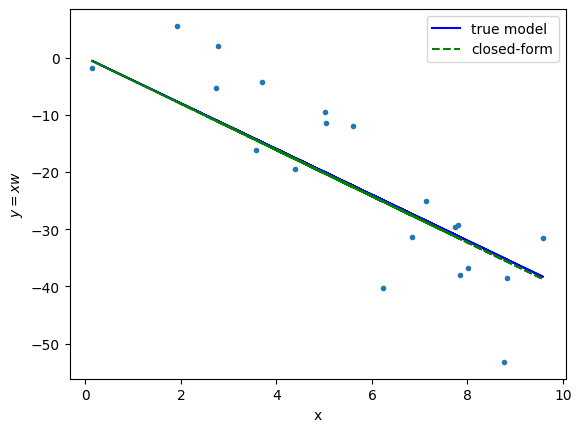

In [4]:
model = LinearRegression(add_bias=False)
model.fit(x, y, optimizer=None, gd=False)
plt.clf()
plt.plot(x, y, '.')
w_closedform = model.w
plt.plot(x, true_w*x, 'b-', label='true model')
plt.plot(x, x*w_closedform, 'g--', label='closed-form')
plt.xlabel('x')
plt.ylabel(r'$y=xw$')
plt.legend()
plt.savefig("linear_fit_closedform.png",bbox_inches='tight', dpi=300)

The closed-form solution is very close to the true model despite the noise.

In [5]:
model.w

array([-4.04060853])

Now let's fit this model to the toy data using gradient descent.

(t,w): (0, [0.])
(t,w): (1, [-1.56678692])
(t,w): (2, [-2.52603632])
(t,w): (3, [-3.11332705])
(t,w): (4, [-3.47288984])
(t,w): (5, [-3.69302852])
(t,w): (6, [-3.82780619])
(t,w): (7, [-3.91032246])
(t,w): (8, [-3.9608422])
(t,w): (9, [-3.99177241])


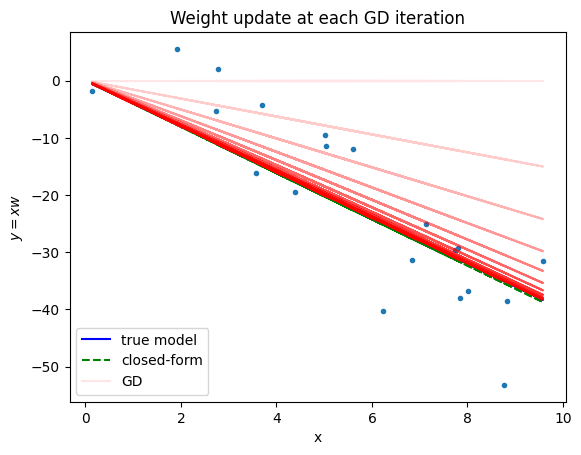

In [6]:
alpha = 1e-2
optimizer = GradientDescent(learning_rate=alpha, max_iters=10, record_history=True)
model = LinearRegression(add_bias=False)
model.fit(x,y, optimizer, gd=True)
plt.clf()
plt.plot(x, y, '.')
plt.plot(x, true_w*x, 'b-', label='true model')
plt.plot(x, w_closedform*x, 'g--', label='closed-form')
losses = []
for t,w in enumerate(optimizer.w_history):
    print(f'(t,w): ({t}, {w})')
    plt.plot(x, x*w, 'r-', alpha=min(1,0.1+t/len(optimizer.w_history)), label="GD" if t == 0 else "")
    losses.append(np.mean((y - x*w)**2))
plt.xlabel('x')
plt.ylabel(r'$y=xw$')
plt.title("Weight update at each GD iteration")
plt.legend()
plt.savefig("toy_gd_update.png",bbox_inches='tight', dpi=300)

The final fitted coefficient after 1000 iterations are also very close to the true solution of -4 and 10:

In [7]:
model.w

array([-3.99177241])

## Visualizing the MSE loss as a function of the fitted coefficents all iterations

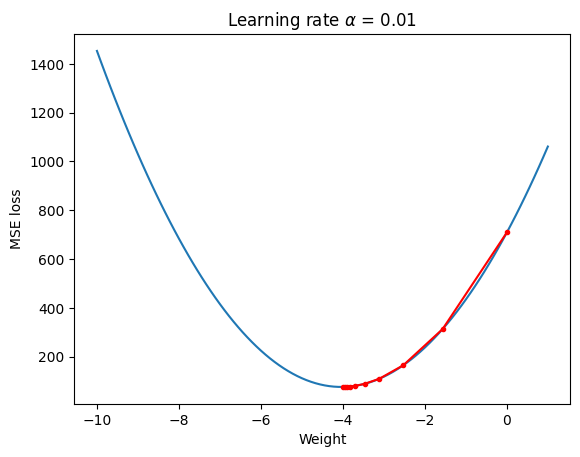

In [8]:
plt.clf()
w_space = np.linspace(-10, 1, 100)
all_losses = [np.mean((y - x*w)**2) for w in w_space]
plt.plot(w_space, all_losses, '-')
plt.plot(optimizer.w_history, losses, 'r.-')
plt.xlabel("Weight")
plt.ylabel("MSE loss")
plt.title(rf"Learning rate $\alpha$ = {alpha}")
plt.savefig("toy_gd_loss.png",bbox_inches='tight', dpi=300)

## Change of learning rate
Next, let's visualize the effect of learning rate on the behaviour of gradient descent in linear regression.

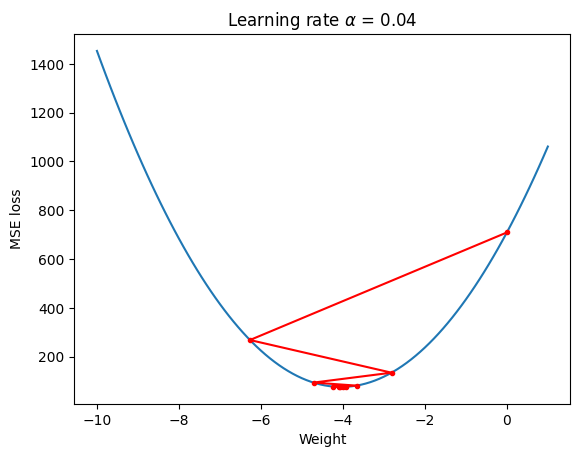

In [9]:
large_alpha = 4e-2
optimizer = GradientDescent(learning_rate=large_alpha, max_iters=10, record_history=True)
model = LinearRegression(add_bias=False)
model.fit(x,y, optimizer, gd=True)
losses_large_lr = []
for t,w in enumerate(optimizer.w_history):
    losses_large_lr.append(np.mean((y - x*w)**2))

w_space = np.linspace(-10, 1, 100)
all_losses_large_lr = [np.mean((y - x*w)**2) for w in w_space]
plt.clf()
plt.title(rf"Learning rate $\alpha$ = {large_alpha}")
plt.plot(w_space, all_losses_large_lr, '-')
plt.plot(optimizer.w_history, losses_large_lr, 'r.-')
plt.xlabel("Weight")
plt.ylabel("MSE loss")
plt.savefig("toy_gd_loss_large_lr.png",bbox_inches='tight', dpi=300)

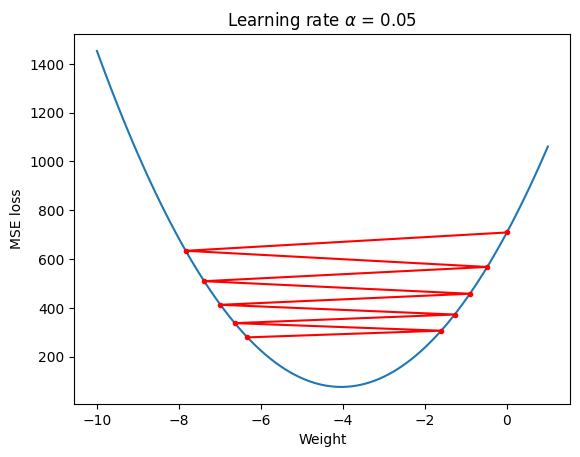

In [10]:
larger_alpha = 5e-2
optimizer = GradientDescent(learning_rate=larger_alpha, max_iters=10, record_history=True)
model = LinearRegression(add_bias=False)
model.fit(x,y, optimizer, gd=True)
losses_larger_lr = []
for t,w in enumerate(optimizer.w_history):
    losses_larger_lr.append(np.mean((y - x*w)**2))

w_space = np.linspace(-10, 1, 100)
all_losses_large_lr = [np.mean((y - x*w)**2) for w in w_space]
plt.clf()
plt.title(rf"Learning rate $\alpha$ = {larger_alpha}")
plt.plot(w_space, all_losses_large_lr, '-')
plt.plot(optimizer.w_history, losses_larger_lr, 'r.-')
plt.xlabel("Weight")
plt.ylabel("MSE loss")
plt.savefig("toy_gd_loss_large_lr.png",bbox_inches='tight', dpi=300)

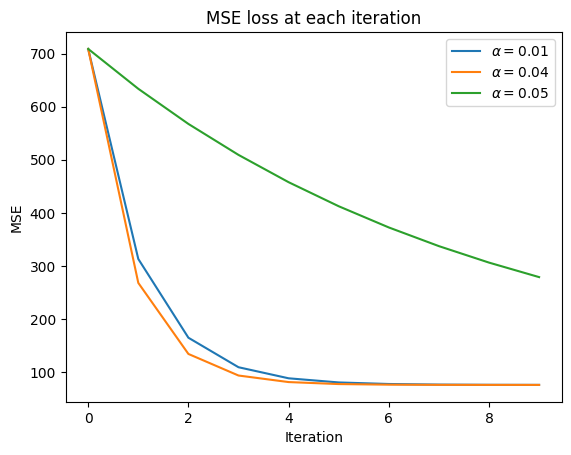

In [11]:
plt.plot([i for i in range(10)], losses, label=rf'$\alpha = {alpha}$')
plt.plot([i for i in range(10)], losses_large_lr, label=rf'$\alpha = {large_alpha}$')
plt.plot([i for i in range(10)], losses_larger_lr, label=rf'$\alpha = {larger_alpha}$')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE loss at each iteration")
plt.savefig("mse_small_vs_large_lr.png",bbox_inches='tight', dpi=300)

For two-dimensional coefficients (slope and bias), we use the plot-contour function to visualize the optimization landscape.

In [12]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Let's track the steps of the
gradient descent using different values for the learning rate.

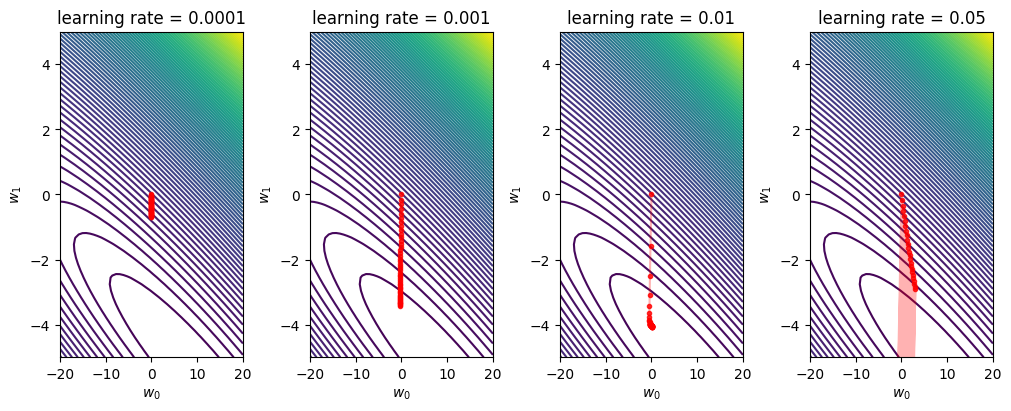

In [13]:
cost = lambda w: 0.5 * np.mean((w[0] + w[1]*x - y)**2)
learning_rates = [1e-4, 1e-3, 1e-2, 5e-2]
fig, axes = plt.subplots(ncols=len(learning_rates), nrows=1, constrained_layout=True, figsize=(10, 4))
costs = []
for i, lr in enumerate(learning_rates):
    optimizer = GradientDescent(learning_rate=lr, max_iters=50, record_history=True)
    model = LinearRegression()
    model.fit(x, y, optimizer)
    plot_contour(cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)                # get the history for plotting
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f'learning rate = {lr}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])

    costs_lr=[]
    for t,w in enumerate(optimizer.w_history):
        costs_lr.append(cost(w))
    costs.append(costs_lr)
# plt.show()
plt.savefig("mse_2d_weight_space.png",bbox_inches='tight', dpi=300)

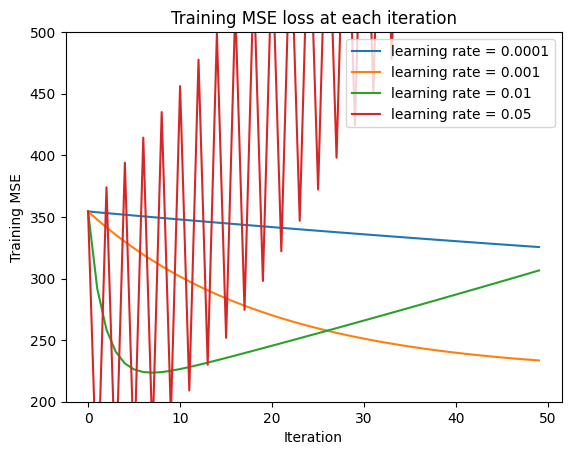

In [14]:
for i, lr in enumerate(learning_rates):
    plt.plot([j for j in range(50)], costs[i], label=f'learning rate = {lr}')
plt.xlabel("Iteration")
plt.ylabel("Training MSE")
plt.ylim([200, 500])
plt.legend()
plt.title("Training MSE loss at each iteration")
plt.savefig("mse_learning_rates.png", bbox_inches='tight', dpi=300)

Batch Gradient Descent update weights right after seeing ALL training example: at each step as a result of which it is very slow on very large training data. Thus, it becomes very computationally expensive to do batch gradient descent.

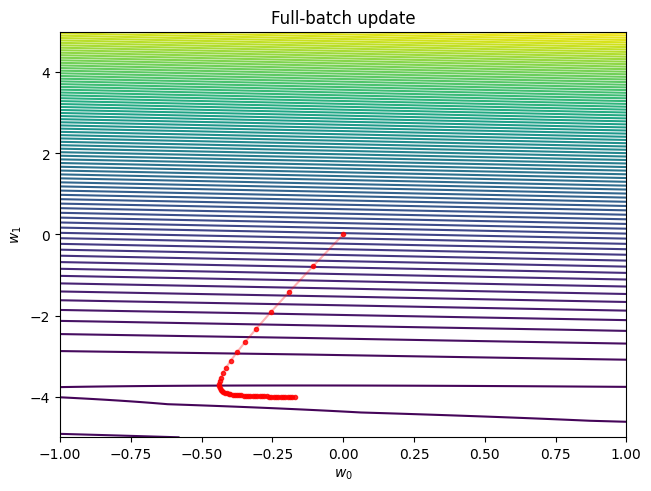

In [15]:
_, axes = plt.subplots(ncols=1, nrows=1, constrained_layout=True)
optimizer = GradientDescent(learning_rate=5e-3, max_iters=50, record_history=True)
model = LinearRegression()

model.fit(x,y, optimizer)
#plot_contour(cost, [-20,20], [-5,5], 50, axes)
plot_contour(cost, [-1,1], [-5,5], 50, axes)                # zoom in
w_hist = np.vstack(optimizer.w_history)                    # get the history for plotting
axes.plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
axes.plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
axes.set_xlabel(r'$w_0$')
axes.set_ylabel(r'$w_1$')
axes.set_title(f'Full-batch update')
# axes.set_xlim([-20,20])
# axes.set_ylim([-5,5])
plt.savefig('fullbatch_update.png', bbox_inches="tight", dpi=300)

## Stochastic gradient updates (SGD)

SGD tries to solve the main problem in Batch Gradient descent which is the usage of whole training data to calculate gradients at each step. SGD updates the weights right after seeing EACH training example, making it much faster as there is much fewer data to manipulate at a single time.

In [16]:
class StochasticGradientDescent:

    def __init__(self, learning_rate=1e-4, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                  # to store the weight history for visualization

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        if self.record_history:
            self.w_history.append(w)                 # store initial weights before the iterative update

        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            for n in range(x.shape[0]):
                grad = gradient_fn(x[n,None], y[n,None], w) # updates the weights right after seeing EACH training example
                w = w - self.learning_rate * grad     # weight update step
                if self.record_history:
                    self.w_history.append(w)
                t += 1
                # print('(t,w)',(t,w))
        return w

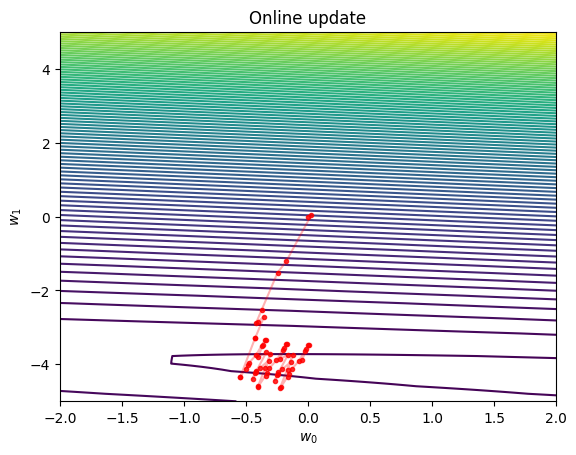

In [17]:
_, axes = plt.subplots(ncols=1, nrows=1)
optimizer = StochasticGradientDescent(learning_rate=5e-3, max_iters=50, record_history=True)
model = LinearRegression()

model.fit(x,y, optimizer)
plot_contour(cost, [-2,2], [-5,5], 50, axes)
w_hist = np.vstack(optimizer.w_history)                    # get the history for plotting
axes.plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
axes.plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
axes.set_xlabel(r'$w_0$')
axes.set_ylabel(r'$w_1$')
axes.set_title(f'Online update')
# axes.set_xlim([-20,20])
# axes.set_ylim([-5,5])
plt.savefig('online_update.png', bbox_inches="tight", dpi=300)